## Import Libraries

In [1]:
## Pre-processing Packages
import pandas as pd
import re
import nltk
import nlpaug.augmenter.word as naw
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler

# download necessary NLTK data (only need to run this once)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /Users/nnerella/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/nnerella/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nnerella/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

# FOR VADER
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import tokenize

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nnerella/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Baseline: Naive Bayes' Classifier

In [90]:
features_train = pd.read_csv('/Users/nnerella/Downloads/features_train.csv')
features_test = pd.read_csv('/Users/nnerella/Downloads/features_test.csv')

In [91]:
label_map = {
    'positive': 1,
    'negative': 0,
}

features_train['Sentiment'] = features_train['Sentiment'].map(label_map)
features_test['Sentiment'] = features_test['Sentiment'].map(label_map)

In [92]:
NB = GaussianNB()
kf = KFold(n_splits=5)
score = cross_val_score(NB, features_train.iloc[: , :-1], features_train['Sentiment'],cv = kf)
print("Cross Validation Scores are {}".format(score))
print("Average Cross Validation score :{}".format(score.mean()))

Cross Validation Scores are [1.         1.         0.92819149 0.97429078 1.        ]
Average Cross Validation score :0.9804964539007092


In [95]:
NB.fit(features_train.iloc[: , :-1], features_train['Sentiment'])
NB_pred= NB.predict(features_test.iloc[: , :-1])
#print(NB_pred)

print(accuracy_score(features_test['Sentiment'], NB_pred))

0.8268053855569155


In [96]:
print("F1 score: ", f1_score(features_test['Sentiment'], NB_pred))
print("PR_AUC score: ", average_precision_score(features_test['Sentiment'], NB_pred))
print("ROC_AUC score: ", roc_auc_score(features_test['Sentiment'], NB_pred))
print("Accuracy: ", accuracy_score(features_test['Sentiment'], NB_pred))

F1 score:  0.8952239911144021
PR_AUC score:  0.8103217158176944
ROC_AUC score:  0.6670588235294117
Accuracy:  0.8268053855569155


## VADER(Valence Aware Dictionary for Sentiment Reasoning)

#### Links for Reference
1. https://www.analyticsvidhya.com/blog/2022/10/sentiment-analysis-using-vader/#:~:text=VADER(%20Valence%20Aware%20Dictionary%20for,as%20either%20positive%20or%20negative.

2. https://stackoverflow.com/questions/45296897/is-there-a-way-to-improve-performance-of-nltk-sentiment-vader-sentiment-analyser

In [3]:
reviews_csv = pd.read_csv('../../data/raw/reviews.csv')

In [4]:
# Convert Sentiment into factor
# Positive: 1, Negative: 0

label_map = {
    'positive': 1,
    'negative': 0,
}
reviews_csv['sentiment_label'] = reviews_csv['Sentiment'].map(label_map)

#### Note: 
1. nltk+vader already do basic pre-processing (such as removing stop-words etc..)
2. Do not remove punctuation, as it helps improve score (Ex. ! -> +ve)

In [5]:
# Remove HTML characters
def remove_html(text):
    regex = r"<[^>]+>"
    text_new = re.sub(regex, " ", text)
    return text_new

reviews_csv['VADER_processed_Text'] = reviews_csv['Text'].apply(lambda para: remove_html(para))

In [6]:
reviews_csv

,Sentiment,Time,Text,sentiment_label,VADER_processed_Text
0,positive,18/6/21,This is a very healthy dog food. Good for thei...,1,This is a very healthy dog food. Good for thei...
1,positive,7/7/21,I've been very pleased with the Natural Balanc...,1,I've been very pleased with the Natural Balanc...
2,positive,18/6/21,"Before I was educated about feline nutrition, ...",1,"Before I was educated about feline nutrition, ..."
3,positive,7/7/21,"My holistic vet recommended this, along with a...",1,"My holistic vet recommended this, along with a..."
4,positive,1/7/21,I bought this coffee because its much cheaper ...,1,I bought this coffee because its much cheaper ...
...,...,...,...,...,...
5439,negative,26/2/21,"This is an okay gift box, only if you like med...",0,"This is an okay gift box, only if you like med..."
5440,negative,18/12/19,It looks llike I just walked into a raw deal. ...,0,It looks llike I just walked into a raw deal. ...
5441,negative,19/1/20,Thank god that i tasted the metal before i swa...,0,Thank god that i tasted the metal before i swa...
5442,negative,13/9/20,This product was very good when I began buying...,0,This product was very good when I began buying...


In [7]:
SIA = SentimentIntensityAnalyzer()
reviews_csv['VADER_dict'] = reviews_csv['VADER_processed_Text'].apply(lambda text: SIA.polarity_scores(text))

reviews_csv.head()

,Sentiment,Time,Text,sentiment_label,VADER_processed_Text,VADER_dict
0,positive,18/6/21,This is a very healthy dog food. Good for thei...,1,This is a very healthy dog food. Good for thei...,"{'neg': 0.0, 'neu': 0.705, 'pos': 0.295, 'comp..."
1,positive,7/7/21,I've been very pleased with the Natural Balanc...,1,I've been very pleased with the Natural Balanc...,"{'neg': 0.031, 'neu': 0.732, 'pos': 0.237, 'co..."
2,positive,18/6/21,"Before I was educated about feline nutrition, ...",1,"Before I was educated about feline nutrition, ...","{'neg': 0.017, 'neu': 0.795, 'pos': 0.188, 'co..."
3,positive,7/7/21,"My holistic vet recommended this, along with a...",1,"My holistic vet recommended this, along with a...","{'neg': 0.079, 'neu': 0.67, 'pos': 0.252, 'com..."
4,positive,1/7/21,I bought this coffee because its much cheaper ...,1,I bought this coffee because its much cheaper ...,"{'neg': 0.0, 'neu': 0.843, 'pos': 0.157, 'comp..."


##### The compound score is the sum of positive, negative & neutral scores which is then normalized between -1(most extreme negative) and +1 (most extreme positive).

In [8]:
# Convert the score to appropriate label {0,1}
reviews_csv['VADER_score'] = reviews_csv['VADER_dict'].apply(lambda sent_dict: sent_dict['compound'])
reviews_csv['VADER_label'] = 0

# If compound > 0 -> 1 else compund < 0 -> 0
reviews_csv.loc[reviews_csv['VADER_score'] > 0, 'VADER_label'] = 1
reviews_csv.loc[reviews_csv['VADER_score'] < 0, 'VADER_label'] = 0
reviews_csv.head()

,Sentiment,Time,Text,sentiment_label,VADER_processed_Text,VADER_dict,VADER_score,VADER_label
0,positive,18/6/21,This is a very healthy dog food. Good for thei...,1,This is a very healthy dog food. Good for thei...,"{'neg': 0.0, 'neu': 0.705, 'pos': 0.295, 'comp...",0.8313,1
1,positive,7/7/21,I've been very pleased with the Natural Balanc...,1,I've been very pleased with the Natural Balanc...,"{'neg': 0.031, 'neu': 0.732, 'pos': 0.237, 'co...",0.9273,1
2,positive,18/6/21,"Before I was educated about feline nutrition, ...",1,"Before I was educated about feline nutrition, ...","{'neg': 0.017, 'neu': 0.795, 'pos': 0.188, 'co...",0.9769,1
3,positive,7/7/21,"My holistic vet recommended this, along with a...",1,"My holistic vet recommended this, along with a...","{'neg': 0.079, 'neu': 0.67, 'pos': 0.252, 'com...",0.9678,1
4,positive,1/7/21,I bought this coffee because its much cheaper ...,1,I bought this coffee because its much cheaper ...,"{'neg': 0.0, 'neu': 0.843, 'pos': 0.157, 'comp...",0.8868,1


In [9]:
print("F1 score: ", f1_score(reviews_csv['sentiment_label'], reviews_csv['VADER_label']))
print("PR_AUC score: ", average_precision_score(reviews_csv['sentiment_label'], reviews_csv['VADER_label']))
print("ROC_AUC score: ", roc_auc_score(reviews_csv['sentiment_label'], reviews_csv['VADER_label']))
print("Accuracy: ", accuracy_score(reviews_csv['sentiment_label'], reviews_csv['VADER_label']))

F1 score:  0.8872441309124551
PR_AUC score:  0.826482206621329
ROC_AUC score:  0.6997636186872852
Accuracy:  0.8209037472446731


#### Let's try to improve scores - 
Instead of calculating polarity score on entire review, we calculate it for each sentatence in text and average it

In [10]:
# Function to calculate Average Vader score: by avergaing score for each sentence in input text
def avg_pol_score(text):
    compound_list = []
    for sent in text:
        dict_ = SIA.polarity_scores(sent)
        compound_list.append(dict_['compound'])

    return np.average(compound_list)

# Tokenize Text
reviews_csv['VADER_processed_Text'] = reviews_csv['VADER_processed_Text'].apply(lambda para: tokenize.sent_tokenize(para))
avg_VADER_score = reviews_csv['VADER_processed_Text'].apply(lambda text: avg_pol_score(text))

In [13]:
reviews_csv['avg_VADER_score'] = pd.DataFrame(avg_VADER_score)
reviews_csv['avg_VADER_score_label'] = 0
reviews_csv.loc[reviews_csv['avg_VADER_score'] > 0, 'avg_VADER_score_label'] = 1
reviews_csv.loc[reviews_csv['avg_VADER_score'] < 0, 'avg_VADER_score_label'] = 0
reviews_csv.head()

,Sentiment,Time,Text,sentiment_label,VADER_processed_Text,VADER_dict,VADER_score,VADER_label,avg_VADER_score,avg_VADER_score_label
0,positive,18/6/21,This is a very healthy dog food. Good for thei...,1,"[This is a very healthy dog food., Good for th...","{'neg': 0.0, 'neu': 0.705, 'pos': 0.295, 'comp...",0.8313,1,0.334600,1
1,positive,7/7/21,I've been very pleased with the Natural Balanc...,1,[I've been very pleased with the Natural Balan...,"{'neg': 0.031, 'neu': 0.732, 'pos': 0.237, 'co...",0.9273,1,0.459625,1
2,positive,18/6/21,"Before I was educated about feline nutrition, ...",1,"[Before I was educated about feline nutrition,...","{'neg': 0.017, 'neu': 0.795, 'pos': 0.188, 'co...",0.9769,1,0.277511,1
3,positive,7/7/21,"My holistic vet recommended this, along with a...",1,"[My holistic vet recommended this, along with ...","{'neg': 0.079, 'neu': 0.67, 'pos': 0.252, 'com...",0.9678,1,0.261840,1
4,positive,1/7/21,I bought this coffee because its much cheaper ...,1,[I bought this coffee because its much cheaper...,"{'neg': 0.0, 'neu': 0.843, 'pos': 0.157, 'comp...",0.8868,1,0.274083,1


In [14]:
print("F1 score: ", f1_score(reviews_csv['sentiment_label'], reviews_csv['avg_VADER_score_label']))
print("PR_AUC score: ", average_precision_score(reviews_csv['sentiment_label'], reviews_csv['avg_VADER_score_label']))
print("ROC_AUC score: ", roc_auc_score(reviews_csv['sentiment_label'], reviews_csv['avg_VADER_score_label']))
print("Accuracy: ", accuracy_score(reviews_csv['sentiment_label'], reviews_csv['avg_VADER_score_label']))

F1 score:  0.8907621247113163
PR_AUC score:  0.8290624565744616
ROC_AUC score:  0.7051979320583601
Accuracy:  0.8262307127112417


#### Drawback of VADER:
The main drawback with the rule-based approach for sentiment analysis is that the method only cares about individual words and completely ignores the context in which it is used. 

For example, “the party was savage” will be negative when considered by any token-based algorithms.

## Flair

In [64]:
from flair.nn import Classifier
from flair.data import Sentence
from flair.splitter import SegtokSentenceSplitter

In [75]:
# DEMO
# load the model
tagger = Classifier.load('sentiment')

# make a sentence
sentence = Sentence('The food was not great. I am impressed')

# predict NER tags
tagger.predict(sentence)

# print sentence with predicted tags
print(sentence)

Sentence[9]: "The food was not great. I am impressed" → NEGATIVE (0.9346)


In [68]:
for l in sentence.get_labels():
    print(l.value)

POSITIVE


In [83]:
#for review in reviews_csv['Text'].to_list():
probs = []
sentiments = []

for tweet in reviews_csv['Text'].to_list():
    # make prediction
    sentence = Sentence(tweet)
    tagger.predict(sentence)
    
    # extract sentiment prediction
    probs.append(sentence.labels[0].score)  # numerical score 0-1
    sentiments.append(sentence.labels[0].value)  # 'POSITIVE' or 'NEGATIVE'

# add probability and sentiment predictions to tweets dataframe
#tweets['probability'] = probs
#tweets['sentiment'] = sentiments
probs

[0.999592125415802,
 0.9943861961364746,
 0.997817873954773,
 0.9999748468399048,
 0.9999879598617554,
 0.9999549388885498,
 0.9994101524353027,
 0.9999359846115112,
 0.9974732995033264,
 0.9997918009757996,
 0.9999006986618042,
 0.9998217225074768,
 0.9999099969863892,
 0.999929666519165,
 0.9996577501296997,
 0.9999294281005859,
 0.9995784163475037,
 0.9999597072601318,
 0.999931812286377,
 0.9997147917747498,
 0.9997983574867249,
 0.9998040795326233,
 0.9978904128074646,
 0.9991366267204285,
 0.9994957447052002,
 0.999823272228241,
 0.994478702545166,
 0.9943796992301941,
 0.9999513626098633,
 0.9534459114074707,
 0.9999542236328125,
 0.9969580173492432,
 0.9814180731773376,
 0.9995989203453064,
 0.9970769882202148,
 0.9999305009841919,
 0.9998323917388916,
 0.9999657869338989,
 0.977097749710083,
 0.9993454813957214,
 0.9998791217803955,
 0.9999581575393677,
 0.999984860420227,
 0.9967645406723022,
 0.9999933242797852,
 0.9984361529350281,
 0.6480453610420227,
 0.9997034668922424,


In [84]:
sentiments

['POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'NEGATIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'POSITIVE',
 'NEGATIVE',

In [88]:
reviews_csv['flair_sentiment'] = np.array(sentiments)

label_map_2 = {
    'POSITIVE': 1,
    'NEGATIVE': 0,
}

reviews_csv['flair_sentiment']  = reviews_csv['flair_sentiment'] .map(label_map_2)
reviews_csv.head()

,Sentiment,Time,Text,sentiment_label,VADER_processed_Text,VADER_dict,VADER_score,VADER_label,avg_VADER_score,avg_VADER_score_label,flair_sentiment
0,positive,18/6/21,This is a very healthy dog food. Good for thei...,1,"[This is a very healthy dog food., Good for th...","{'neg': 0.0, 'neu': 0.705, 'pos': 0.295, 'comp...",0.8313,1,0.334600,1,1
1,positive,7/7/21,I've been very pleased with the Natural Balanc...,1,[I've been very pleased with the Natural Balan...,"{'neg': 0.031, 'neu': 0.732, 'pos': 0.237, 'co...",0.9273,1,0.459625,1,1
2,positive,18/6/21,"Before I was educated about feline nutrition, ...",1,"[Before I was educated about feline nutrition,...","{'neg': 0.017, 'neu': 0.795, 'pos': 0.188, 'co...",0.9769,1,0.277511,1,0
3,positive,7/7/21,"My holistic vet recommended this, along with a...",1,"[My holistic vet recommended this, along with ...","{'neg': 0.079, 'neu': 0.67, 'pos': 0.252, 'com...",0.9678,1,0.261840,1,1
4,positive,1/7/21,I bought this coffee because its much cheaper ...,1,[I bought this coffee because its much cheaper...,"{'neg': 0.0, 'neu': 0.843, 'pos': 0.157, 'comp...",0.8868,1,0.274083,1,1


In [89]:
print("F1 score: ", f1_score(reviews_csv['sentiment_label'], reviews_csv['flair_sentiment']))
print("PR_AUC score: ", average_precision_score(reviews_csv['sentiment_label'], reviews_csv['flair_sentiment']))
print("ROC_AUC score: ", roc_auc_score(reviews_csv['sentiment_label'], reviews_csv['flair_sentiment']))
print("Accuracy: ", accuracy_score(reviews_csv['sentiment_label'], reviews_csv['flair_sentiment']))

F1 score:  0.9579445225616772
PR_AUC score:  0.9704845475144125
ROC_AUC score:  0.9486224251634663
Accuracy:  0.9395664952241


## Spacy

Refernce: https://www.section.io/engineering-education/sentiment-analysis-with-spacy-and-scikit-learn/

Using Spacy tokeiser and linear SVC (SVM)

### Results (vectorizer)
- F1 score:  0.9232273838630808

- PR_AUC score:  0.9089266836550011

- ROC_AUC score:  0.8446448118914558

- Accuracy : 0.884643644379133

### Results (tfvectorizer)
- F1 score:  0.9364161849710984

- PR_AUC score:  0.9131134755677366

- ROC_AUC score:  0.8539450941983062

- Accuracy : 0.9030124908155768

## Pattern

### Results (Variant 1)
- F1 score:  0.8754691231661549

- PR_AUC score:  0.8050572447178244

- ROC_AUC score:  0.6543468189427947

- Accuracy : 0.7988611315209405

### Results (Variant 2)
- F1 score:  0.8740791896869244

- PR_AUC score:  0.8108267234637438

- ROC_AUC score:  0.6666363658698375

- Accuracy : 0.799044819985305

## Compare Models

In [100]:
models = ["Naive Bayes", "Vader(Avg)", "Flair", "Spacy(Tfvector)", "Pattern"]
F1_scores = [0.8952239911144021,  0.8907621247113163, 0.9579445225616772, 0.9364161849710984, 0.8740791896869244]
PR_AUC_scores = [0.8103217158176944,  0.8290624565744616, 0.9704845475144125, 0.9131134755677366, 0.8108267234637438]
ROC_AUC_scores = [0.6670588235294117, 0.7051979320583601,  0.9486224251634663, 0.8539450941983062, 0.6666363658698375]
Accuracy_scores = [0.8268053855569155, 0.8262307127112417, 0.9395664952241, 0.9030124908155768, 0.799044819985305]    

performance = pd.DataFrame(list(zip(models, F1_scores, PR_AUC_scores, ROC_AUC_scores, Accuracy_scores)),
               columns =['models','F1_scores', 'PR_AUC_scores', 'ROC_AUC_scores', 'Accuracy_scores'])

In [101]:
performance

,models,F1_scores,PR_AUC_scores,ROC_AUC_scores,Accuracy_scores
0,Naive Bayes,0.895224,0.810322,0.667059,0.826805
1,Vader(Avg),0.890762,0.829062,0.705198,0.826231
2,Flair,0.957945,0.970485,0.948622,0.939566
3,Spacy(Tfvector),0.936416,0.913113,0.853945,0.903012
4,Pattern,0.874079,0.810827,0.666636,0.799045


In [137]:
# Matplotlib for additional customization
from matplotlib import pyplot as plt
%matplotlib inline

# Seaborn for plotting and styling
import seaborn as sns

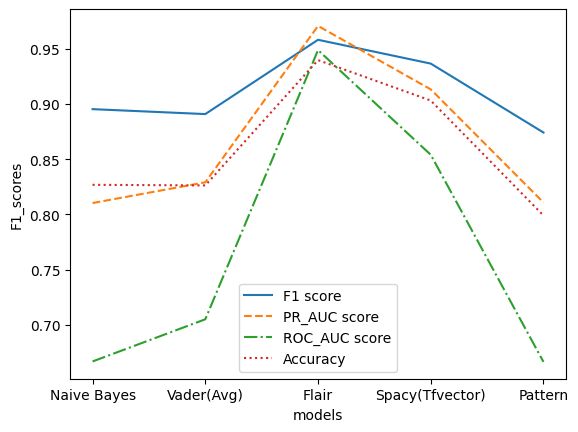

In [136]:
sns.lineplot(x = "models", y = "F1_scores", data=performance, label = "F1 score", linestyle="-", )
sns.lineplot(x = "models", y = "PR_AUC_scores", data=performance, label = "PR_AUC score", linestyle="--")
sns.lineplot(x = "models", y = "ROC_AUC_scores", data=performance, label = "ROC_AUC score", linestyle="dashdot")
sns.lineplot(x = "models", y = "Accuracy_scores", data=performance, label = "Accuracy", linestyle="dotted")
plt.show()